# Non-NN Baselines train and evaluation
Loops over each data object in a given root folder and runs the four non-NN baseline models over it. Saves calculated prediction values and the models into separate lists. Finally, generates ROC curves for each fold and calculates the mean AUC and standard deviation of AUC for each specified model.

Note: this notebook is designed to load in data from a directory that has processed data objects created from a notebook in 'src/Data Object Generation/'. You need data objects calculated from that folder before running this notebook.

In [1]:
# Sets seed for Pytorch Lightning, sklearn, numpy, etc.
SEED = 1

# root path to process raw dataset
root_path = '../../data/lab-oversampled-mixed5,0.65'

In [2]:
## Standard libraries
import os
import os.path as osp
import numpy as np 
import pandas as pd
from dtw import *

## Imports for plotting
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchmetrics import F1Score

# Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from torch_geometric.data import Dataset, download_url, Data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay

# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

# Setting the seed
pl.seed_everything(SEED)
np.random.seed(SEED)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Global seed set to 1


cuda:0


In [3]:
# Dataset class definition that loads the 10 data objects created 
# by tenfold_cross_val on a given root directory. 
# Cannot process / generate its own data: you must first run 
# tenfold_cross_val on the given root directory in the given notebook 
# in 'src/Data Object Generation' with the raw data files x_pd.csv, 
# y_pd.csv, and imputed_lab.csv. 

# NOTE: TODO make std. sampled datasets for non-NN stuff
class TenfoldDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.num_classes = 2
        

    @property
    def raw_file_names(self):
        return ['x_pd.csv', 'y_pd.csv', 'imputed_lab.csv']

    @property
    def processed_file_names(self):
        return ['data_0.pt', 'data_1.pt', 'data_2.pt', 'data_3.pt', 'data_4.pt', 
                'data_5.pt', 'data_6.pt', 'data_7.pt', 'data_8.pt', 'data_9.pt']

    def download(self):
        pass

    def process(self):
        raise Exception('Please use tenfold_cross_val to generate the .pt files for this dataset.')
    
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [4]:
# implements LogisticRegression and automates training/testing.
# Returns: trained model, test ground truths, 1d probabilites from model
def train_test_logR(X_train, y_train, X_test, y_test):
    # init, train & test Random Forest
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # calculate prob_1d
    probabilities = model.predict_proba(X_test)
    prob_1d = np.zeros(len(probabilities)) # <- need 1d arr to input in roc_auc_score
    for i in range(len(probabilities)):
        prob_1d[i] = probabilities[i][1] - probabilities[i][0]
    
    return model, prob_1d 

In [5]:
# implements k-Nearest Neighbors and automates training/testing.
# Returns: trained model, test ground truths, 1d probabilites from model
def train_test_knn(X_train, y_train, X_test, y_test):
    # init, train & test Random Forest
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)

    # calculate prob_1d
    probabilities = model.predict_proba(X_test)
    prob_1d = np.zeros(len(probabilities)) # <- need 1d arr to input in roc_auc_score
    for i in range(len(probabilities)):
        prob_1d[i] = probabilities[i][1] - probabilities[i][0]
    
    return model, prob_1d 

In [6]:
# implements Random Forest and automates training/testing.
# Returns: trained model, test ground truths, 1d probabilites from model
def train_test_rf(X_train, y_train, X_test, y_test):
    # init, train & test Random Forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # calculate prob_1d
    probabilities = model.predict_proba(X_test)
    prob_1d = np.zeros(len(probabilities)) # <- need 1d arr to input in roc_auc_score
    for i in range(len(probabilities)):
        prob_1d[i] = probabilities[i][1] - probabilities[i][0]
    
    return model, prob_1d 

In [7]:
# implements SVC and automates training/testing.
# Returns: trained model, test ground truths, 1d probabilites from model
def train_test_svc(X_train, y_train, X_test, y_test):
    # init, train & test Random Forest
    model = SVC(probability=True)
    model.fit(X_train, y_train)

    # calculate prob_1d
    probabilities = model.predict_proba(X_test)
    prob_1d = np.zeros(len(probabilities)) # <- need 1d arr to input in roc_auc_score
    for i in range(len(probabilities)):
        prob_1d[i] = probabilities[i][1] - probabilities[i][0]
    
    return model, prob_1d 

In [8]:
# creates graph of ROC curve based on k-fold list of ground truths
# and 1-dimensional array of probability. lightly modified sample code from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def ROC_kfoldCV(y_tests, prob_lists, fig_title="Receiver operating characteristic"):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(7, 5.5), dpi=80)

    for i in range(len(y_tests)):
        viz = RocCurveDisplay.from_predictions(
            y_tests[i],
            prob_lists[i],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    print('mean AUC:', mean_auc)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=fig_title,
    )
    ax.legend(loc="lower right")
    plt.show()

In [9]:
# creates lightly modified sample code from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def get_mean_curve(y_tests, prob_lists, fig_title="Receiver operating characteristic", save_folder=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(7, 5.5), dpi=80)

    for i in range(len(y_tests)):
        viz = RocCurveDisplay.from_predictions(
            y_tests[i],
            prob_lists[i],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            # ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    print(type(mean_auc))
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    print('mean AUC:', mean_auc)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(
#         mean_fpr,
#         tprs_lower,
#         tprs_upper,
#         color="grey",
#         alpha=0.2,
#         label=r"$\pm$ 1 std. dev.",
#     )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=fig_title,
    )
    ax.legend(loc="lower right")
    plt.show()
    
    # save mean_auc, std_auc, mean_tpr, & mean_fpr into file
    if save_folder != None:
        np.savetxt(save_folder + '/mean_fpr.csv', mean_fpr, delimiter=',')
        np.savetxt(save_folder + '/mean_tpr.csv', mean_tpr, delimiter=',')
        np.savetxt(save_folder + '/mean_auc.csv', np.array([mean_auc]), delimiter=',')
        np.savetxt(save_folder + '/std_auc.csv', np.array([std_auc]), delimiter=',')

In [10]:
results_list_logR, prob_list_logR  = [], []
results_list_knn, prob_list_knn  = [], []
results_list_rf, prob_list_rf  = [], []
results_list_svc, prob_list_svc  = [], []
y_test_list = []

tenfold_data = TenfoldDataset(root=root_path)

for i in range(10):
    print('\nStarting round', i + 1, 'of 10\n-------------------------')
    # extra X train, X test, y train & y test from ith data object
    tenfold_i = tenfold_data[i:i + 1]
    
    x_train = tenfold_i[0].x[tenfold_i[0].train_mask].numpy().tolist()
    y_train = tenfold_i[0].y[tenfold_i[0].train_mask].numpy().tolist()
    # make validation part of testing
    test_mask = tenfold_i[0].val_mask.numpy() + tenfold_i[0].test_mask.numpy()
    x_test = tenfold_i[0].x[test_mask].numpy().tolist()
    y_test = tenfold_i[0].y[test_mask].numpy().tolist()

    # init, train & test Logistic Regression w/ lab
    model_logR, prob_logR = train_test_rf(x_train, y_train, x_test, y_test)
    print('LogR auc score:', roc_auc_score(y_test, prob_logR))
    
    # init, train & test kNN w/ lab
    model_knn, prob_knn = train_test_rf(x_train, y_train, x_test, y_test)
    print('KNN auc score:', roc_auc_score(y_test, prob_knn))
    
    # init, train & test Random Forest w/ lab
    model_rf, prob_rf = train_test_rf(x_train, y_train, x_test, y_test)
    print('RF auc score:', roc_auc_score(y_test, prob_rf))

    # init, train & test SVC w/ lab
    model_svc, prob_svc = train_test_svc(x_train, y_train, x_test, y_test)
    print('SVC auc score:', roc_auc_score(y_test, prob_svc))

    results_list_logR += [model_logR]
    results_list_knn += [model_knn]
    results_list_rf += [model_rf]
    results_list_svc += [model_svc]
    
    prob_list_logR += [prob_logR]
    prob_list_knn += [prob_knn]
    prob_list_rf += [prob_rf]
    prob_list_svc += [prob_svc]
    
    y_test_list += [y_test]
    print()


Starting round 1 of 10
-------------------------
LogR auc score: 0.7104952830188679
KNN auc score: 0.7194303338171263
RF auc score: 0.7235123367198838
SVC auc score: 0.726233671988389


Starting round 2 of 10
-------------------------
LogR auc score: 0.7630624092888244
KNN auc score: 0.7054154571843251
RF auc score: 0.7602503628447024
SVC auc score: 0.6782474600870827


Starting round 3 of 10
-------------------------
LogR auc score: 0.759500385802469
KNN auc score: 0.7425250771604938
RF auc score: 0.779513888888889
SVC auc score: 0.6413966049382717


Starting round 4 of 10
-------------------------
LogR auc score: 0.7764680295780773
KNN auc score: 0.7603740756850803
RF auc score: 0.7463679860809047
SVC auc score: 0.6189647672901262


Starting round 5 of 10
-------------------------
LogR auc score: 0.7091444806903083
KNN auc score: 0.7333999789540145
RF auc score: 0.6970430390403031
SVC auc score: 0.6158055350941808


Starting round 6 of 10
-------------------------
LogR auc score: 0.

mean AUC: 0.7127722354398378


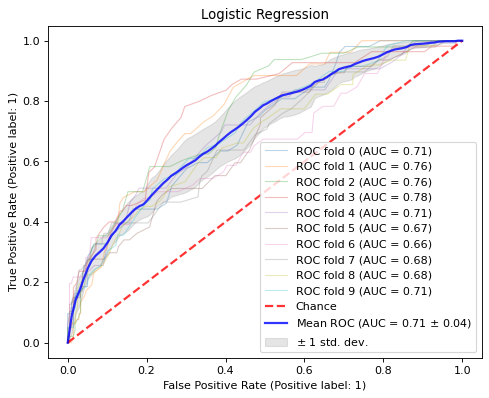

mean AUC: 0.7099892842478611


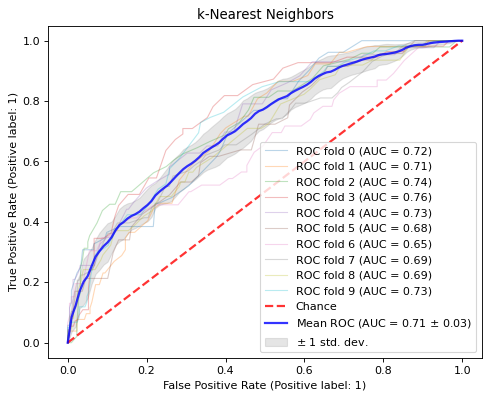

mean AUC: 0.7121206728813342


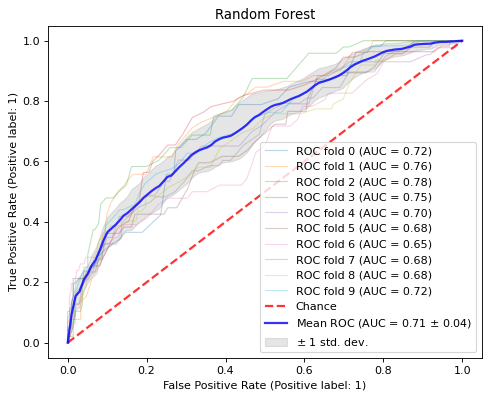

mean AUC: 0.6641619584966145


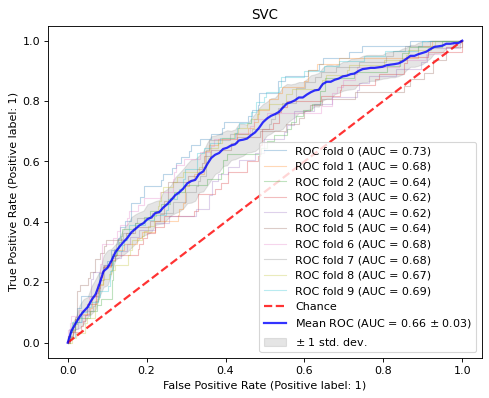

In [11]:
ROC_kfoldCV(y_test_list, prob_list_logR, 'Logistic Regression')
ROC_kfoldCV(y_test_list, prob_list_knn, 'k-Nearest Neighbors')
ROC_kfoldCV(y_test_list, prob_list_rf, 'Random Forest')
ROC_kfoldCV(y_test_list, prob_list_svc, 'SVC')

<class 'numpy.float64'>
mean AUC: 0.7127722354398378


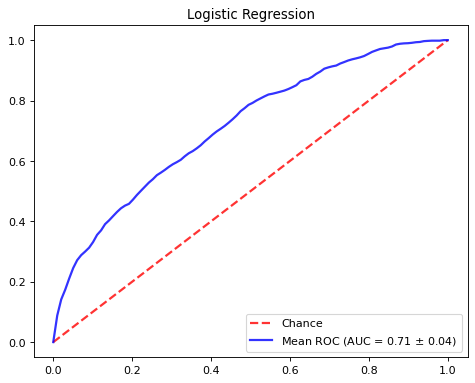

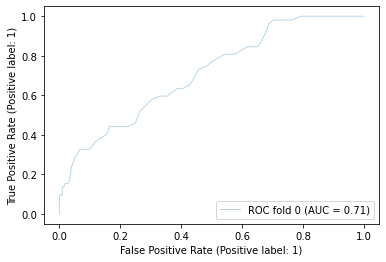

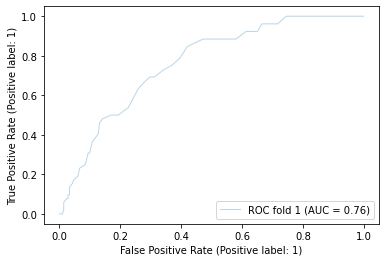

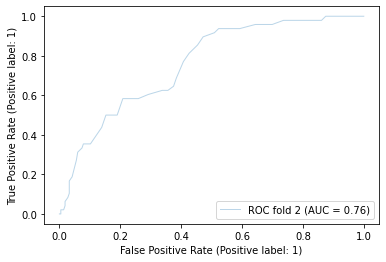

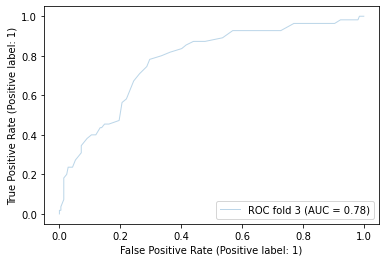

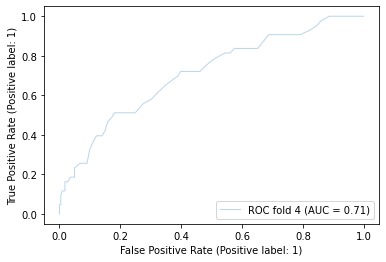

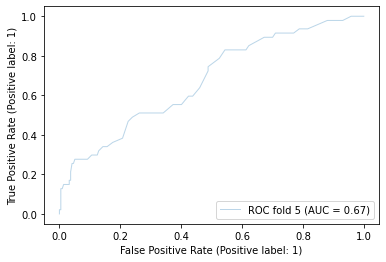

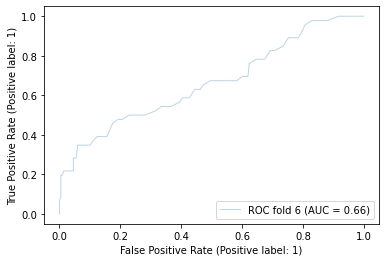

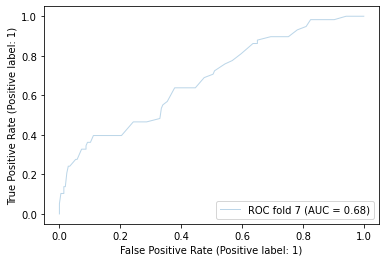

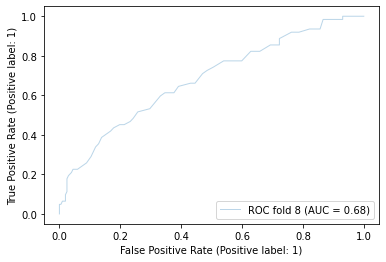

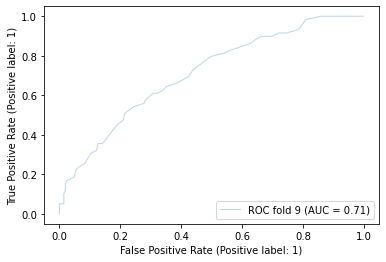

In [12]:
get_mean_curve(y_test_list, prob_list_logR, 'Logistic Regression', './ROC Curves/LogR')


<class 'numpy.float64'>
mean AUC: 0.7099892842478611


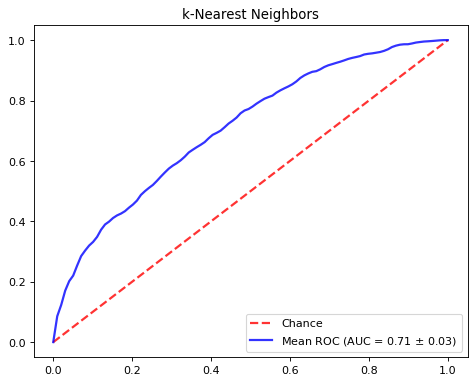

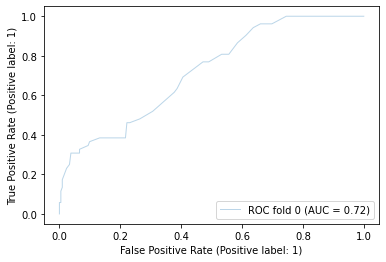

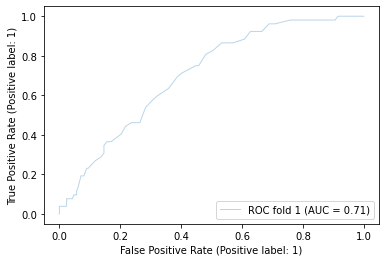

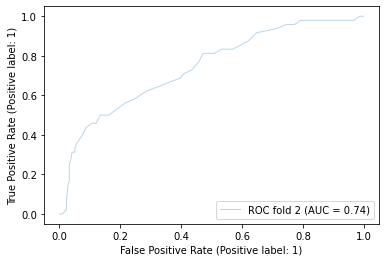

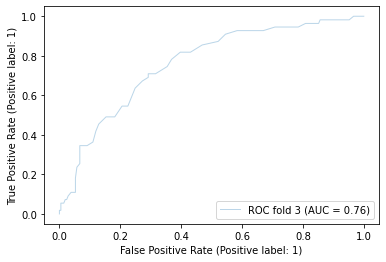

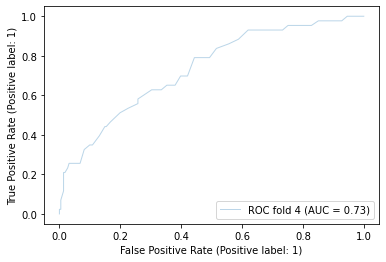

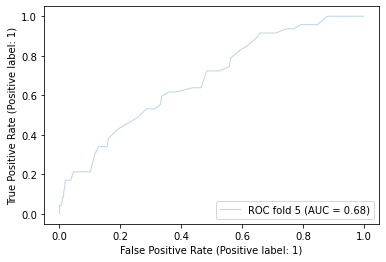

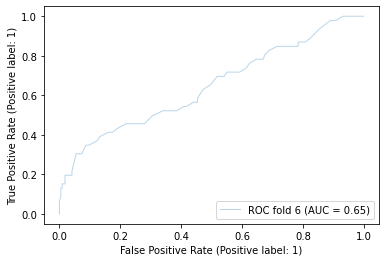

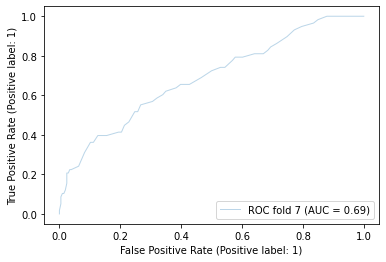

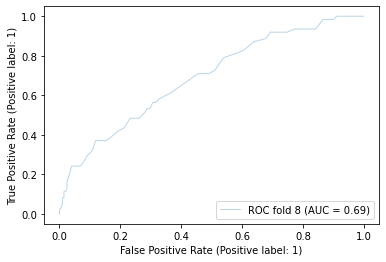

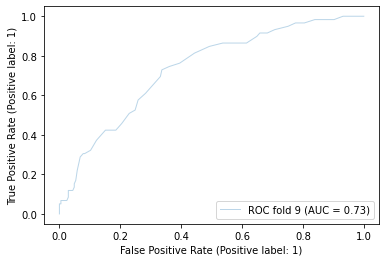

In [13]:
get_mean_curve(y_test_list, prob_list_knn, 'k-Nearest Neighbors', './ROC Curves/kNN')

<class 'numpy.float64'>
mean AUC: 0.7121206728813342


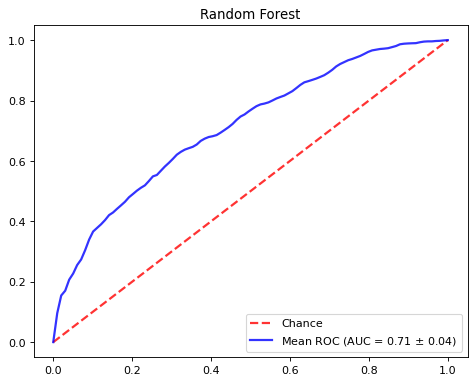

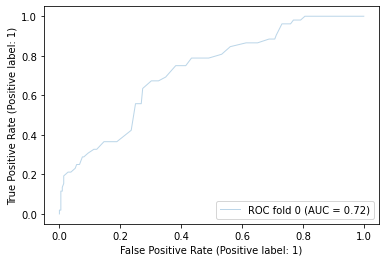

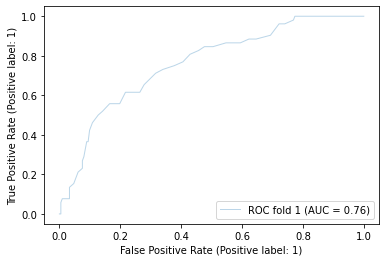

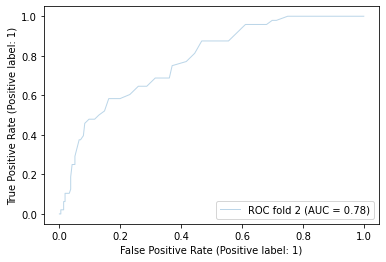

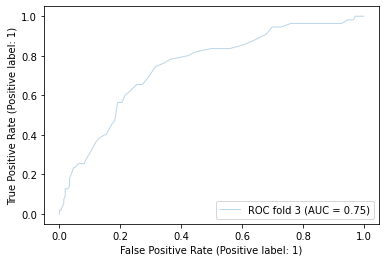

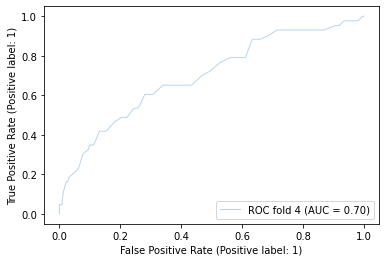

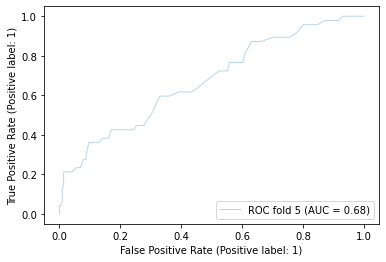

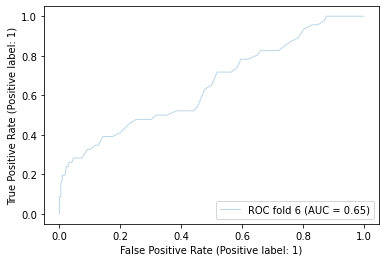

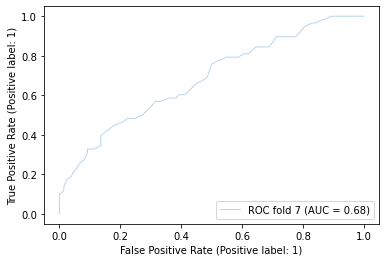

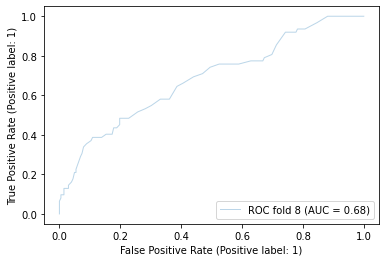

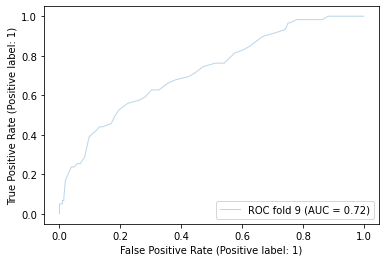

In [14]:
get_mean_curve(y_test_list, prob_list_rf, 'Random Forest', './ROC Curves/RF')

<class 'numpy.float64'>
mean AUC: 0.6641619584966145


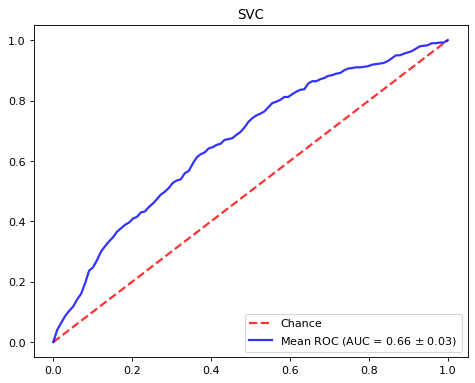

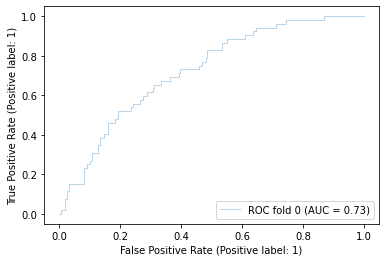

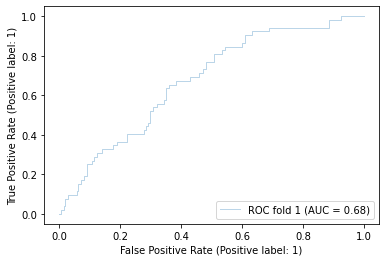

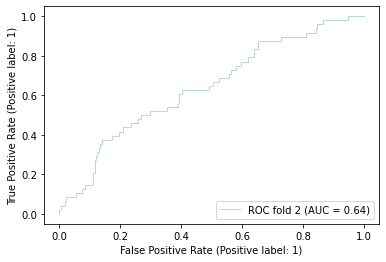

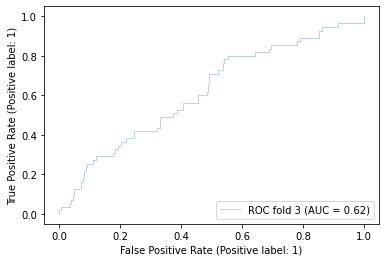

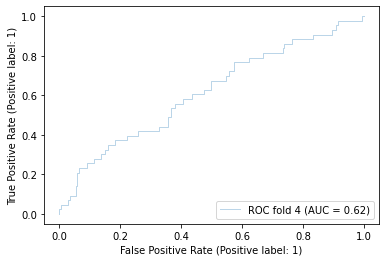

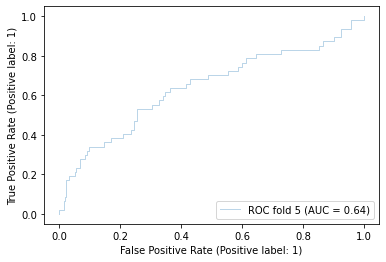

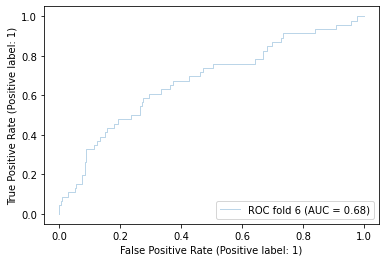

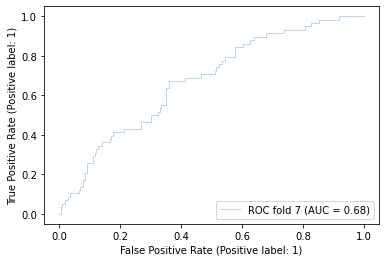

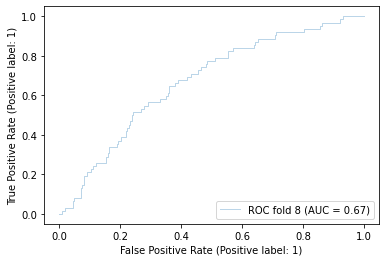

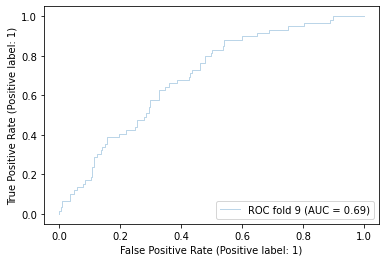

In [15]:
get_mean_curve(y_test_list, prob_list_svc, 'SVC', './ROC Curves/SVC')